In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb,albumentations as A

#import IPython.display as disp
from timm.data import Mixup
from timm.data.random_erasing import RandomErasing as RandomErasingTimm
from timm.loss import SoftTargetCrossEntropy
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [2]:
%env WANDB_SILENT=true
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [3]:
VERSION  = "NB_EXP_015"
EXP_NAME = f"{VERSION}_maxvit_rmlp_tiny_rw"

MODEL_FOLDER = Path(f'/runs/{VERSION}')

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')

os.makedirs(MODEL_FOLDER, exist_ok=True)

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

TIMM_MODEL  = "maxvit_rmlp_tiny_rw_256"

NFOLDS = 5
BS = 32
SZ = 256

TRAIN_AUG = A.Compose([
    A.Resize(SZ, SZ),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=360, border_mode=0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Blur(p=0.5),
    A.CoarseDropout(max_height=int(32*(SZ/512)), max_width=int(32*(SZ/512)), p=0.75), 
])

CROP_PCT = 1.0
SCALE_SZ = int(math.floor(SZ / CROP_PCT))
VALID_AUG = A.Compose([A.Resize(SCALE_SZ, SCALE_SZ), A.CenterCrop(SZ, SZ)])

In [4]:
all_df = pd.read_csv(CSV_PATH)

folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

folds.head()

,seed_id,view,image,label,fold
0,0,top,train/00000.png,broken,0
1,1,bottom,train/00001.png,pure,3
2,3,top,train/00003.png,broken,2
3,4,top,train/00004.png,pure,3
4,5,top,train/00005.png,discolored,4


In [5]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)


class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [6]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]

In [7]:
def get_dls(fold:int, bs:int, *args, **kwargs):
    
    item_tfms = [ToTensor, AlbumentationsTransform(TRAIN_AUG,VALID_AUG)]
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

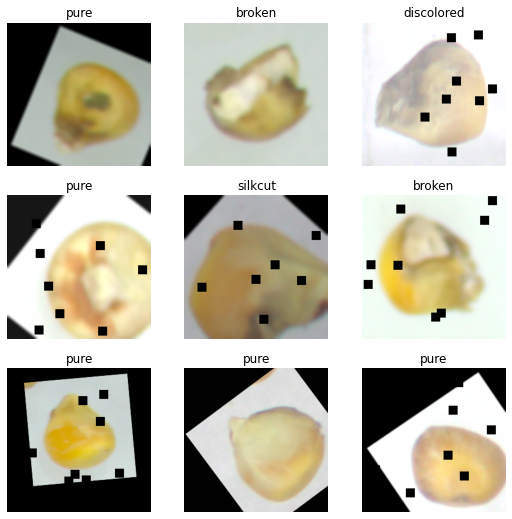

In [8]:
dls = get_dls(0, BS)
dls.show_batch()

In [9]:
def build_experiment(fold:int = 0, pretrained:bool=True):
    print(f' model:{TIMM_MODEL}; pretrained:{pretrained}')
    print(f' fold:{fold}; sz:{SZ}; bs:{BS}')
    
    dls = get_dls(fold, bs=BS)
    
    learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=pretrained,
                           loss_func=CrossEntropyLossFlat(), metrics=[accuracy]).to_fp16()
    return dls, learn


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:0; sz:256; bs:32


SuggestedLRs(valley=0.0010000000474974513, slide=0.0012022644514217973)
CPU: 1856/46/3285 MB | GPU: 940/5554/2001 MB | Time 0:00:13.970 | (Consumed/Peaked/Used Total)


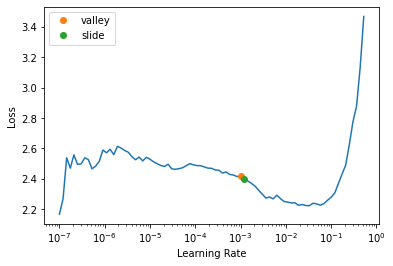

In [10]:
set_seed(42); set_fast_norm()

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):      
    dls, learn = build_experiment(0)
    print(learn.lr_find(suggest_funcs=(valley, slide)))

In [13]:
n_epo = 15; base_lr = 0.003;
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_mixup_ft"

In [14]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, 
                        save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            print()
            print('*' * 100)
            print(f'Training fold {fold_idx}')
            print('*' * 100)
        
            dls, learn = build_experiment(fold_idx)
            print(f' epochs:{n_epo}; base_lr:{base_lr}')
            
            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   MixUp(0.4),
                   WandbCallback(log_preds=None)]
            
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 0
****************************************************************************************************
 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:0; sz:256; bs:32
 epochs:15; base_lr:0.003


epoch,train_loss,valid_loss,accuracy,time
0,1.297982,1.079175,0.559511,00:50


Better model found at epoch 0 with accuracy value: 0.5595113635063171.


epoch,train_loss,valid_loss,accuracy,time
0,1.105882,0.882180,0.625131,01:11
1,1.016214,0.787105,0.672600,01:12
2,0.962054,0.700216,0.712391,01:12
3,0.914273,0.715376,0.692147,01:12
4,0.874558,0.616574,0.753578,01:12
5,0.833036,0.630202,0.750087,01:12
6,0.809896,0.558934,0.776265,01:12
7,0.791378,0.553370,0.782897,01:12
8,0.790057,0.534400,0.784293,01:12
9,0.765194,0.528259,0.790576,01:12


Better model found at epoch 0 with accuracy value: 0.6251308917999268.
Better model found at epoch 1 with accuracy value: 0.6726003289222717.
Better model found at epoch 2 with accuracy value: 0.7123908996582031.
Better model found at epoch 4 with accuracy value: 0.7535776495933533.
Better model found at epoch 6 with accuracy value: 0.7762652635574341.
Better model found at epoch 7 with accuracy value: 0.7828970551490784.
Better model found at epoch 8 with accuracy value: 0.7842931747436523.
Better model found at epoch 9 with accuracy value: 0.7905759215354919.
Better model found at epoch 10 with accuracy value: 0.79301917552948.
Better model found at epoch 11 with accuracy value: 0.7954624891281128.
Better model found at epoch 13 with accuracy value: 0.7968586683273315.
Better model found at epoch 14 with accuracy value: 0.7986038327217102.
CPU: 363/90/3650 MB | GPU: 638/6298/2639 MB | Time 0:19:21.010 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Dev

epoch,train_loss,valid_loss,accuracy,time
0,1.313131,1.268749,0.447469,00:51


Better model found at epoch 0 with accuracy value: 0.44746947288513184.


epoch,train_loss,valid_loss,accuracy,time
0,1.089722,0.831516,0.654799,01:12
1,0.997241,0.823769,0.665620,01:12
2,0.953112,0.710141,0.709599,01:13
3,0.908220,0.648571,0.738220,01:13
4,0.877740,0.675335,0.734380,01:13
5,0.827712,0.637208,0.736475,01:13
6,0.815770,0.597950,0.763351,01:13
7,0.803193,0.578706,0.766841,01:13
8,0.793364,0.547377,0.789180,01:12
9,0.779249,0.539513,0.781501,01:13


Better model found at epoch 0 with accuracy value: 0.6547992825508118.
Better model found at epoch 1 with accuracy value: 0.6656195521354675.
Better model found at epoch 2 with accuracy value: 0.7095986008644104.
Better model found at epoch 3 with accuracy value: 0.7382199168205261.
Better model found at epoch 6 with accuracy value: 0.763350784778595.
Better model found at epoch 7 with accuracy value: 0.7668411731719971.
Better model found at epoch 8 with accuracy value: 0.7891797423362732.
Better model found at epoch 10 with accuracy value: 0.8027923107147217.
CPU: 30/91/3680 MB | GPU: 368/6268/3007 MB | Time 0:19:29.682 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 2
****************************************************************************************************
 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:2; sz:256; bs:32
 epochs:15; base_lr:0.003


epoch,train_loss,valid_loss,accuracy,time
0,1.326190,1.043658,0.556913,00:51


Better model found at epoch 0 with accuracy value: 0.556913435459137.


epoch,train_loss,valid_loss,accuracy,time
0,1.070077,0.880522,0.639665,01:12
1,0.998472,0.796490,0.676676,01:12
2,0.947700,0.736240,0.703561,01:13
3,0.910300,0.701236,0.709497,01:12
4,0.870732,0.599765,0.764316,01:13
5,0.837114,0.589400,0.761173,01:12
6,0.803511,0.562938,0.775838,01:13
7,0.776819,0.538546,0.785615,01:12
8,0.780885,0.533425,0.781425,01:12
9,0.778184,0.539918,0.786662,01:13


Better model found at epoch 0 with accuracy value: 0.6396648287773132.
Better model found at epoch 1 with accuracy value: 0.6766759753227234.
Better model found at epoch 2 with accuracy value: 0.7035614252090454.
Better model found at epoch 3 with accuracy value: 0.7094972133636475.
Better model found at epoch 4 with accuracy value: 0.764315664768219.
Better model found at epoch 6 with accuracy value: 0.7758380174636841.
Better model found at epoch 7 with accuracy value: 0.785614550113678.
Better model found at epoch 9 with accuracy value: 0.7866619825363159.
Better model found at epoch 10 with accuracy value: 0.7898044586181641.
Better model found at epoch 11 with accuracy value: 0.7957402467727661.
Better model found at epoch 12 with accuracy value: 0.7974860072135925.
Better model found at epoch 13 with accuracy value: 0.7978351712226868.
CPU: 1/90/3682 MB | GPU: -2/6262/3005 MB | Time 0:19:25.664 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device


****************************************************************************************************
Training fold 3
****************************************************************************************************
 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:3; sz:256; bs:32
 epochs:15; base_lr:0.003


epoch,train_loss,valid_loss,accuracy,time
0,1.333903,1.025101,0.549581,00:51


Better model found at epoch 0 with accuracy value: 0.549580991268158.


epoch,train_loss,valid_loss,accuracy,time
0,1.091020,0.864698,0.643855,01:12
1,1.024626,0.755313,0.689595,01:13
2,0.935856,0.705688,0.716480,01:13
3,0.907276,0.664857,0.731844,01:13
4,0.875306,0.597627,0.765363,01:13
5,0.848458,0.579626,0.770251,01:13
6,0.816067,0.544541,0.790154,01:13
7,0.805505,0.522516,0.795391,01:13
8,0.784164,0.514698,0.796089,01:13
9,0.772231,0.519353,0.792249,01:13


Better model found at epoch 0 with accuracy value: 0.6438547372817993.
Better model found at epoch 1 with accuracy value: 0.6895949840545654.
Better model found at epoch 2 with accuracy value: 0.7164804339408875.
Better model found at epoch 3 with accuracy value: 0.7318435907363892.
Better model found at epoch 4 with accuracy value: 0.7653631567955017.
Better model found at epoch 5 with accuracy value: 0.7702513933181763.
Better model found at epoch 6 with accuracy value: 0.7901536226272583.
Better model found at epoch 7 with accuracy value: 0.7953910827636719.
Better model found at epoch 8 with accuracy value: 0.7960894107818604.
Better model found at epoch 11 with accuracy value: 0.8030726313591003.
Better model found at epoch 12 with accuracy value: 0.8041201233863831.
CPU: 0/90/3683 MB | GPU: 176/6104/3181 MB | Time 0:19:28.964 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 4
****************************************************************************************************
 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:4; sz:256; bs:32
 epochs:15; base_lr:0.003


epoch,train_loss,valid_loss,accuracy,time
0,1.305182,1.029835,0.571578,00:51


Better model found at epoch 0 with accuracy value: 0.5715782046318054.


epoch,train_loss,valid_loss,accuracy,time
0,1.101060,0.890817,0.632332,01:12
1,1.016280,0.773833,0.693436,01:12
2,0.944700,0.677902,0.723813,01:12
3,0.897823,0.637355,0.732193,01:12
4,0.884716,0.570230,0.766411,01:12
5,0.840568,0.575668,0.774441,01:12
6,0.807070,0.566739,0.774791,01:12
7,0.791436,0.519692,0.791550,01:12
8,0.792490,0.504213,0.799581,01:13
9,0.765619,0.500116,0.795391,01:13


Better model found at epoch 0 with accuracy value: 0.6323323845863342.
Better model found at epoch 1 with accuracy value: 0.6934357285499573.
Better model found at epoch 2 with accuracy value: 0.7238128781318665.
Better model found at epoch 3 with accuracy value: 0.7321927547454834.
Better model found at epoch 4 with accuracy value: 0.7664105892181396.
Better model found at epoch 5 with accuracy value: 0.7744413614273071.
Better model found at epoch 6 with accuracy value: 0.7747905254364014.
Better model found at epoch 7 with accuracy value: 0.7915502786636353.
Better model found at epoch 8 with accuracy value: 0.799580991268158.
Better model found at epoch 10 with accuracy value: 0.8062151074409485.
Better model found at epoch 12 with accuracy value: 0.8097066879272461.
Better model found at epoch 14 with accuracy value: 0.8100558519363403.
CPU: 1/88/3684 MB | GPU: 274/5956/3455 MB | Time 0:19:24.034 | (Consumed/Peaked/Used Total)


In [20]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls, learn = build_experiment(fold_index, pretrained=False)
        learn.model_dir = Path(MODEL_FOLDER)
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"==> Load checkpoint from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
        # hflip + vflip augs
        tst_dl_hlip_vflip = dls.valid.new()
        tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip,tst_dl_hlip_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:0; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_maxvit_rmlp_tiny_rw_256_bs32_epo15_mixup_ft_CV_00' (00)


* Accuracy : 0.8027923107147217

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:1; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_maxvit_rmlp_tiny_rw_256_bs32_epo15_mixup_ft_CV_01' (01)


* Accuracy : 0.8055846691131592

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:2; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_maxvit_rmlp_tiny_rw_256_bs32_epo15_mixup_ft_CV_02' (02)


* Accuracy : 0.8034217953681946

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:3; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_maxvit_rmlp_tiny_rw_256_bs32_epo15_mixup_ft_CV_03' (03)


* Accuracy : 0.8114525079727173

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:4; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_maxvit_rmlp_tiny_rw_256_bs32_epo15_mixup_ft_CV_04' (04)


* Accuracy : 0.8100558519363403

CPU: 30/13/3942 MB | GPU: 162/1196/2291 MB | Time 0:01:48.572 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.80279, 0.80558, 0.80342, 0.81145, 0.81006]
Avg: 0.80666
Std: 0.00350


In [21]:
n_epo = 10; base_lr = 0.005;

VERSION  = "NB_EXP_015_V2"
EXP_NAME = f"{VERSION}_maxvit_rmlp_tiny_rw"
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_mixup_ft"

In [22]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, 
                        save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            print()
            print('*' * 100)
            print(f'Training fold {fold_idx}')
            print('*' * 100)
        
            dls, learn = build_experiment(fold_idx)
            print(f' epochs:{n_epo}; base_lr:{base_lr}')
            
            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   WandbCallback(log_preds=None)]
            
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 0
****************************************************************************************************
 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:0; sz:256; bs:32
 epochs:10; base_lr:0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.210740,1.035441,0.588831,00:51


Better model found at epoch 0 with accuracy value: 0.5888307094573975.


epoch,train_loss,valid_loss,accuracy,time
0,0.884465,0.780671,0.684817,01:11
1,0.756459,0.722279,0.726353,01:12
2,0.707424,0.734089,0.697033,01:12
3,0.650924,0.648700,0.740663,01:12
4,0.609041,0.564025,0.779058,01:12
5,0.552282,0.531695,0.785689,01:12
6,0.495155,0.502656,0.795462,01:12
7,0.460163,0.508117,0.790925,01:12
8,0.458490,0.498344,0.794764,01:12
9,0.447274,0.498139,0.793368,01:12


Better model found at epoch 0 with accuracy value: 0.6848167777061462.
Better model found at epoch 1 with accuracy value: 0.7263525128364563.
Better model found at epoch 3 with accuracy value: 0.7406631708145142.
Better model found at epoch 4 with accuracy value: 0.7790575623512268.
Better model found at epoch 5 with accuracy value: 0.7856893539428711.
Better model found at epoch 6 with accuracy value: 0.7954624891281128.
CPU: 0/48/3941 MB | GPU: 770/6116/3061 MB | Time 0:13:12.728 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 1
****************************************************************************************************
 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:1; sz:256; bs:32
 epochs:10; base_lr:0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.239897,1.068275,0.556370,00:51


Better model found at epoch 0 with accuracy value: 0.556369960308075.


epoch,train_loss,valid_loss,accuracy,time
0,0.911912,0.763871,0.682373,01:12
1,0.774592,0.715576,0.707155,01:12
2,0.700358,0.617752,0.756021,01:13
3,0.631146,0.567480,0.776963,01:12
4,0.630270,0.531444,0.783944,01:13
5,0.553507,0.527196,0.783246,01:13
6,0.512783,0.494035,0.804188,01:12
7,0.488213,0.496268,0.798604,01:12
8,0.474240,0.474962,0.806632,01:12
9,0.460853,0.476240,0.807330,01:12


Better model found at epoch 0 with accuracy value: 0.6823734641075134.
Better model found at epoch 1 with accuracy value: 0.7071553468704224.
Better model found at epoch 2 with accuracy value: 0.7560209631919861.
Better model found at epoch 3 with accuracy value: 0.7769633531570435.
Better model found at epoch 4 with accuracy value: 0.7839441299438477.
Better model found at epoch 6 with accuracy value: 0.8041884899139404.
Better model found at epoch 8 with accuracy value: 0.8066317439079285.
Better model found at epoch 9 with accuracy value: 0.8073298335075378.
CPU: 3/47/3945 MB | GPU: 176/6146/3237 MB | Time 0:13:18.672 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 2
****************************************************************************************************
 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:2; sz:256; bs:32
 epochs:10; base_lr:0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.242026,1.035149,0.576816,00:51


Better model found at epoch 0 with accuracy value: 0.576815664768219.


epoch,train_loss,valid_loss,accuracy,time
0,0.895037,0.769427,0.687151,01:12
1,0.775071,0.678383,0.726606,01:12
2,0.688383,0.690674,0.739874,01:13
3,0.621615,0.605908,0.758380,01:12
4,0.584266,0.596241,0.774441,01:13
5,0.549114,0.529873,0.780726,01:13
6,0.506391,0.522467,0.788408,01:12
7,0.473300,0.499776,0.794693,01:12
8,0.473201,0.493965,0.799930,01:12
9,0.447810,0.500791,0.798883,01:12


Better model found at epoch 0 with accuracy value: 0.6871508359909058.
Better model found at epoch 1 with accuracy value: 0.7266061305999756.
Better model found at epoch 2 with accuracy value: 0.7398743033409119.
Better model found at epoch 3 with accuracy value: 0.7583798766136169.
Better model found at epoch 4 with accuracy value: 0.7744413614273071.
Better model found at epoch 5 with accuracy value: 0.7807262539863586.
Better model found at epoch 6 with accuracy value: 0.7884078025817871.
Better model found at epoch 7 with accuracy value: 0.7946927547454834.
Better model found at epoch 8 with accuracy value: 0.7999301552772522.
CPU: 0/44/3945 MB | GPU: 4/6142/3241 MB | Time 0:13:17.604 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 3
****************************************************************************************************
 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:3; sz:256; bs:32
 epochs:10; base_lr:0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.216530,1.130526,0.547486,00:51


Better model found at epoch 0 with accuracy value: 0.5474860072135925.


epoch,train_loss,valid_loss,accuracy,time
0,0.887304,0.797381,0.668994,01:12
1,0.791015,0.682124,0.734986,01:12
2,0.719943,0.622213,0.746508,01:13
3,0.654589,0.555391,0.775140,01:13
4,0.626617,0.556422,0.777933,01:13
5,0.574975,0.512104,0.790503,01:12
6,0.535500,0.490997,0.807961,01:12
7,0.492930,0.486797,0.805168,01:13
8,0.446610,0.483978,0.799232,01:12
9,0.450295,0.481049,0.811453,01:13


Better model found at epoch 0 with accuracy value: 0.6689944267272949.
Better model found at epoch 1 with accuracy value: 0.7349860072135925.
Better model found at epoch 2 with accuracy value: 0.7465083599090576.
Better model found at epoch 3 with accuracy value: 0.7751396894454956.
Better model found at epoch 4 with accuracy value: 0.7779329419136047.
Better model found at epoch 5 with accuracy value: 0.7905027866363525.
Better model found at epoch 6 with accuracy value: 0.8079608678817749.
Better model found at epoch 9 with accuracy value: 0.8114525079727173.
CPU: 0/44/3946 MB | GPU: 166/5976/3407 MB | Time 0:13:19.185 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 4
****************************************************************************************************
 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:4; sz:256; bs:32
 epochs:10; base_lr:0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.226948,1.402262,0.541201,00:51


Better model found at epoch 0 with accuracy value: 0.541201114654541.


epoch,train_loss,valid_loss,accuracy,time
0,0.896828,0.766902,0.691341,01:12
1,0.763840,0.631770,0.745112,01:13
2,0.719594,0.612237,0.755587,01:13
3,0.628903,0.595582,0.765712,01:12
4,0.601615,0.543850,0.794344,01:12
5,0.569066,0.538109,0.778980,01:12
6,0.523336,0.478681,0.808310,01:12
7,0.482134,0.483675,0.800628,01:12
8,0.497967,0.467506,0.812151,01:12
9,0.453055,0.465877,0.809358,01:13


Better model found at epoch 0 with accuracy value: 0.6913408041000366.
Better model found at epoch 1 with accuracy value: 0.7451117038726807.
Better model found at epoch 2 with accuracy value: 0.755586564540863.
Better model found at epoch 3 with accuracy value: 0.7657122611999512.
Better model found at epoch 4 with accuracy value: 0.7943435907363892.
Better model found at epoch 6 with accuracy value: 0.8083100318908691.
Better model found at epoch 8 with accuracy value: 0.8121508359909058.
CPU: 0/46/3946 MB | GPU: 50/5924/3457 MB | Time 0:13:16.433 | (Consumed/Peaked/Used Total)


In [23]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls, learn = build_experiment(fold_index, pretrained=False)
        learn.model_dir = Path(MODEL_FOLDER)
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"==> Load checkpoint from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
        # hflip + vflip augs
        tst_dl_hlip_vflip = dls.valid.new()
        tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip,tst_dl_hlip_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:0; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_V2_maxvit_rmlp_tiny_rw_256_bs32_epo10_mixup_ft_CV_00' (00)


* Accuracy : 0.7954624891281128

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:1; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_V2_maxvit_rmlp_tiny_rw_256_bs32_epo10_mixup_ft_CV_01' (01)


* Accuracy : 0.8157067894935608

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:2; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_V2_maxvit_rmlp_tiny_rw_256_bs32_epo10_mixup_ft_CV_02' (02)


* Accuracy : 0.806913435459137

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:3; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_V2_maxvit_rmlp_tiny_rw_256_bs32_epo10_mixup_ft_CV_03' (03)


* Accuracy : 0.8093575239181519

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:4; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_V2_maxvit_rmlp_tiny_rw_256_bs32_epo10_mixup_ft_CV_04' (04)


* Accuracy : 0.8152933120727539

CPU: 5/10/3951 MB | GPU: -750/868/2707 MB | Time 0:01:49.531 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.79546, 0.81571, 0.80691, 0.80936, 0.81529]
Avg: 0.80855
Std: 0.00737


In [26]:
n_epo = 10; base_lr = 0.005;

VERSION  = "NB_EXP_015_V3"
EXP_NAME = f"{VERSION}_maxvit_rmlp_tiny_rw"
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_cutmix_ft"
MODEL_FOLDER = Path(f'/runs/{VERSION}')
MODEL_FOLDER.mkdir(exist_ok=True)

In [27]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, 
                        save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            print()
            print('*' * 100)
            print(f'Training fold {fold_idx}')
            print('*' * 100)
        
            dls, learn = build_experiment(fold_idx)
            print(f' epochs:{n_epo}; base_lr:{base_lr}')
            
            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   WandbCallback(log_preds=None),CutMix(1.0)]
            
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 0
****************************************************************************************************
 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:0; sz:256; bs:32
 epochs:10; base_lr:0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.358740,1.101211,0.542757,00:51


Better model found at epoch 0 with accuracy value: 0.5427573919296265.


epoch,train_loss,valid_loss,accuracy,time
0,1.150759,0.924690,0.613264,01:12
1,1.090276,0.818458,0.679581,01:13
2,1.043412,0.736813,0.711344,01:13
3,0.999569,0.643276,0.759162,01:13
4,0.974521,0.629975,0.749040,01:13
5,0.921503,0.595439,0.772077,01:13
6,0.925299,0.562341,0.780454,01:13
7,0.883314,0.546797,0.790227,01:13
8,0.884807,0.537719,0.790227,01:13
9,0.861520,0.537742,0.786038,01:13


Better model found at epoch 0 with accuracy value: 0.6132635474205017.
Better model found at epoch 1 with accuracy value: 0.6795811653137207.
Better model found at epoch 2 with accuracy value: 0.7113438248634338.
Better model found at epoch 3 with accuracy value: 0.7591623067855835.
Better model found at epoch 5 with accuracy value: 0.7720767855644226.
Better model found at epoch 6 with accuracy value: 0.7804537415504456.
Better model found at epoch 7 with accuracy value: 0.7902268767356873.
CPU: 0/41/3950 MB | GPU: 876/5592/3583 MB | Time 0:13:24.150 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 1
****************************************************************************************************
 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:1; sz:256; bs:32
 epochs:10; base_lr:0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.371540,1.628675,0.359860,00:51


Better model found at epoch 0 with accuracy value: 0.3598603904247284.


epoch,train_loss,valid_loss,accuracy,time
0,1.128021,0.906057,0.622339,01:13
1,1.102462,0.853575,0.636649,01:13
2,1.052775,0.729116,0.721117,01:14
3,0.997082,0.634534,0.751483,01:14
4,0.973761,0.610291,0.761955,01:14
5,0.921832,0.562648,0.772775,01:13
6,0.943758,0.547162,0.785689,01:13
7,0.888955,0.528724,0.792321,01:13
8,0.903973,0.520160,0.799651,01:14
9,0.884533,0.513283,0.799651,01:14


Better model found at epoch 0 with accuracy value: 0.622338593006134.
Better model found at epoch 1 with accuracy value: 0.6366491913795471.
Better model found at epoch 2 with accuracy value: 0.7211169004440308.
Better model found at epoch 3 with accuracy value: 0.7514834403991699.
Better model found at epoch 4 with accuracy value: 0.7619546055793762.
Better model found at epoch 5 with accuracy value: 0.772774875164032.
Better model found at epoch 6 with accuracy value: 0.7856893539428711.
Better model found at epoch 7 with accuracy value: 0.7923211455345154.
Better model found at epoch 8 with accuracy value: 0.7996509671211243.
CPU: 1/43/3951 MB | GPU: -128/5804/3455 MB | Time 0:13:27.805 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 2
****************************************************************************************************
 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:2; sz:256; bs:32
 epochs:10; base_lr:0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.374375,1.132612,0.514316,00:51


Better model found at epoch 0 with accuracy value: 0.514315664768219.


epoch,train_loss,valid_loss,accuracy,time
0,1.121614,0.874967,0.636522,01:13
1,1.083685,0.762364,0.700419,01:13
2,1.044635,0.779289,0.692737,01:13
3,0.984446,0.639466,0.743017,01:13
4,0.965550,0.598633,0.767109,01:14
5,0.915414,0.587896,0.773394,01:13
6,0.934563,0.539094,0.789804,01:13
7,0.879904,0.528930,0.797835,01:13
8,0.891052,0.521683,0.795042,01:13
9,0.879572,0.520320,0.795391,01:13


Better model found at epoch 0 with accuracy value: 0.6365223526954651.
Better model found at epoch 1 with accuracy value: 0.700419008731842.
Better model found at epoch 3 with accuracy value: 0.74301677942276.
Better model found at epoch 4 with accuracy value: 0.7671089172363281.
Better model found at epoch 5 with accuracy value: 0.7733938694000244.
Better model found at epoch 6 with accuracy value: 0.7898044586181641.
Better model found at epoch 7 with accuracy value: 0.7978351712226868.
CPU: 0/43/3951 MB | GPU: -450/5930/3005 MB | Time 0:13:26.742 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 3
****************************************************************************************************
 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:3; sz:256; bs:32
 epochs:10; base_lr:0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.389637,1.239724,0.472765,00:51


Better model found at epoch 0 with accuracy value: 0.47276535630226135.


epoch,train_loss,valid_loss,accuracy,time
0,1.130613,0.894687,0.646648,01:12
1,1.128054,0.820094,0.661662,01:13
2,1.057621,0.750624,0.704609,01:13
3,1.026484,0.658445,0.743017,01:13
4,0.986969,0.598341,0.772346,01:14
5,0.939724,0.581103,0.775838,01:13
6,0.951411,0.538965,0.786313,01:14
7,0.896979,0.522119,0.796439,01:14
8,0.905037,0.522431,0.796788,01:14
9,0.891840,0.515066,0.797486,01:14


Better model found at epoch 0 with accuracy value: 0.6466480493545532.
Better model found at epoch 1 with accuracy value: 0.6616619825363159.
Better model found at epoch 2 with accuracy value: 0.7046089172363281.
Better model found at epoch 3 with accuracy value: 0.74301677942276.
Better model found at epoch 4 with accuracy value: 0.7723463773727417.
Better model found at epoch 5 with accuracy value: 0.7758380174636841.
Better model found at epoch 6 with accuracy value: 0.7863128781318665.
Better model found at epoch 7 with accuracy value: 0.7964385747909546.
Better model found at epoch 8 with accuracy value: 0.7967877388000488.
Better model found at epoch 9 with accuracy value: 0.7974860072135925.
CPU: 0/44/3951 MB | GPU: 84/6280/3089 MB | Time 0:13:30.040 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 4
****************************************************************************************************
 model:maxvit_rmlp_tiny_rw_256; pretrained:True
 fold:4; sz:256; bs:32
 epochs:10; base_lr:0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.360599,1.357575,0.504888,00:52


Better model found at epoch 0 with accuracy value: 0.5048882961273193.


epoch,train_loss,valid_loss,accuracy,time
0,1.144579,0.910639,0.630936,01:13
1,1.084605,0.775706,0.708450,01:13
2,1.041223,0.694924,0.717179,01:13
3,0.990818,0.616086,0.760126,01:14
4,0.989080,0.553873,0.780028,01:14
5,0.913550,0.554798,0.788757,01:13
6,0.954080,0.567622,0.786313,01:13
7,0.900587,0.522322,0.798184,01:13
8,0.892857,0.506308,0.809358,01:13
9,0.875591,0.501778,0.806215,01:14


Better model found at epoch 0 with accuracy value: 0.6309357285499573.
Better model found at epoch 1 with accuracy value: 0.7084497213363647.
Better model found at epoch 2 with accuracy value: 0.7171787619590759.
Better model found at epoch 3 with accuracy value: 0.7601256966590881.
Better model found at epoch 4 with accuracy value: 0.7800279259681702.
Better model found at epoch 5 with accuracy value: 0.7887569665908813.
Better model found at epoch 7 with accuracy value: 0.798184335231781.
Better model found at epoch 8 with accuracy value: 0.8093575239181519.
CPU: 0/43/3952 MB | GPU: 120/6176/3209 MB | Time 0:13:29.510 | (Consumed/Peaked/Used Total)


In [28]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls, learn = build_experiment(fold_index, pretrained=False)
        learn.model_dir = Path(MODEL_FOLDER)
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"==> Load checkpoint from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
        # hflip + vflip augs
        tst_dl_hlip_vflip = dls.valid.new()
        tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip,tst_dl_hlip_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:0; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_V3_maxvit_rmlp_tiny_rw_256_bs32_epo10_cutmix_ft_CV_00' (00)


* Accuracy : 0.7975566983222961

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:1; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_V3_maxvit_rmlp_tiny_rw_256_bs32_epo10_cutmix_ft_CV_01' (01)


* Accuracy : 0.8048865795135498

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:2; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_V3_maxvit_rmlp_tiny_rw_256_bs32_epo10_cutmix_ft_CV_02' (02)


* Accuracy : 0.8044692873954773

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:3; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_V3_maxvit_rmlp_tiny_rw_256_bs32_epo10_cutmix_ft_CV_03' (03)


* Accuracy : 0.8048184514045715

 model:maxvit_rmlp_tiny_rw_256; pretrained:False
 fold:4; sz:256; bs:32
==> Load checkpoint from : 'NB_EXP_015_V3_maxvit_rmlp_tiny_rw_256_bs32_epo10_cutmix_ft_CV_04' (04)


* Accuracy : 0.8107541799545288

CPU: 3/10/3955 MB | GPU: -764/856/2445 MB | Time 0:01:49.514 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.79756, 0.80489, 0.80447, 0.80482, 0.81075]
Avg: 0.80450
Std: 0.00419
